# 03 - Classification with Naive Bayes
In this section, we will assess the performance of various Naive Bayes models. In particular, we will examine, in order of complexity:
- Bernoulli Naive Bayes with term presence vectors
- Multinomial Naive Bayes with term frequency vectors
- Multinomial Naive Bayes with [td-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency, inverse document frequency) vectors

[Naive Bayes classifiers](http://sebastianraschka.com/Articles/2014_naive_bayes_1.html) are based off Bayes' theorem of conditional probability, and though they are simple, have performed well particularly for text classification. They are labelled naive because the model assumes conditional independence of features, that is, the presence of a word in a tweet does not affect the probability of other words being observed in the same tweet. Though this assumption does not hold, in practice, the violation of conditional independence does not significantly undermine the accuracy of Naive Bayes in text classification.

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

pd.options.display.max_colwidth = 400
%matplotlib inline

### Load data
Because Naive Bayes models classify tweets from their [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) representation, these models do not account for the sequence or semantic meaning of words. Thus, the difference between "swam" and "swimming" is inconsequential to the model, and both words should be represented with the same root of "swim" to prevent an explosion in tweet vector dimensionality. Controlling dimensionality is of special concern given the limited number of tweets in the corpus, and for this reason, stop words, which contribute little to no useful information about the offensiveness of a tweet, should also be ignored. So for classification with Naive Bayes models, we will use lemmatized tweets generated from **02 - Data Wrangling**. 

In [403]:
data_path = os.path.join('..','data','dataframe_clean')
with open(data_path, 'rb') as file_in:
    df_clean = pkl.load(file_in)
    
df_clean.head(3)

,text,rating,confidence
id,,,
853718217,warning penny board faggot,1,0.6013
853718218,fuck dyke,2,0.7227
853718219,look like jefree starr faggot,2,0.5229


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Bernoulli Naive Bayes with term presence vectors
Given a corpus with a vocabulary of size $v$, each tweet can be represented by a $v$-dimensional vector where each index is associated with a unique term in the vocabulary, a value of 1 indicates the presence of that term in the tweet, and 0 indicates otherwise. Because each tweet is converted to a vector of binary features, a Bernoulli Naive Bayes model can be applied to learn the offensiveness of each tweet.

### Create train and test set
Of the roughly 13,000 tweets, we hold out 30% for the test set and ensure the proportion of non-offensive, offensive, and hateful tweets are the same for both training and test sets.

In [300]:
# Extract cleaned text of each tweet and split into training and test sets
X = df_clean.text
X_train, X_test, y_train, y_test = train_test_split(df_clean.text, df_clean.rating,
                                                    test_size = 0.3, stratify = df_clean.rating, random_state = 1)

### Construct and fit pipeline
We build a pipeline consisting of a count vectorizer that converts tweets into binary vectors and the Bernoulli Naive Bayes classifier itself. To optimize the model, we grid search through combinations of hyperparameters:
- **min_df**: A term with a document frequency (the proportion of documents that contain said term) below this threshold is omitted from the vocabulary. This is useful for removing terms that are so rare that they can cause a model to overfit on their infrequent presence.
- **max_df**: A term with a document frequency above this threshold is omitted from the vocabulary. This serves a similar function to removing stop words, but adapts to the contents of a corpus.
- **alpha**: A value for calculating a fail-safe probability in the event of observing an unknown term in the test set.

In [ ]:
steps = [('vect', CountVectorizer(binary=True)), ('bnb', BernoulliNB())]
pipe = Pipeline(steps)

parameters = {'vect__min_df': np.arange(0,0.010, 0.002),
              'vect__max_df': np.arange(.10,.142, 0.005),
              'bnb__alpha': np.arange(0.0,0.4,0.05)}

pipe_cv_bnb = GridSearchCV(pipe, param_grid = parameters, cv = 3, scoring = 'accuracy')
pipe_cv_bnb.fit(X_train, y_train)
print('Best parameters:\n', pipe_cv_bnb.best_params_)
print('Best accuracy: ', pipe_cv_bnb.best_score_)

Optimized hyperparameters produce a Bernoulli Naive Bayes model with a cross-validated accuracy of 0.775. Of particular interest is the surprisingly low max_df hyperparameter, which suggests just removing stop words fell far short of pruning the vocabulary of extraneous terms.

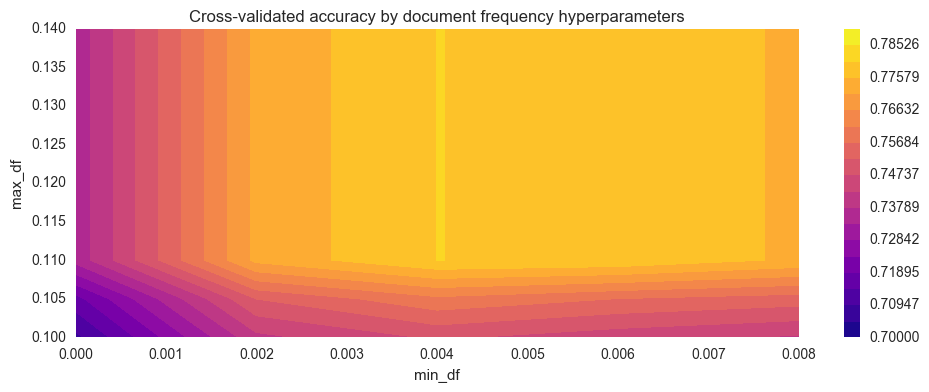

In [402]:
cv_scores = [score[1] for score in pipe_cv_bnb.grid_scores_ if score[0]['bnb__alpha'] == 0.30000000000000004]
min_df = pipe_cv_bnb.param_grid['vect__min_df']
max_df = pipe_cv_bnb.param_grid['vect__max_df']
cv_scores = np.array(cv_scores).reshape(len(max_df), len(min_df))
cv_scores

plt.figure(figsize = (10, 4))
g = plt.contourf(min_df, max_df, cv_scores, cmap = 'plasma', levels = np.linspace(0.7, 0.79, 20))
plt.colorbar(g)
plt.title('Cross-validated accuracy by document frequency hyperparameters')
plt.xlabel('min_df')
plt.ylabel('max_df')
plt.tight_layout()

In fact, the vocabulary used by the model consists of only 261 terms. We can even feed each term back into the model as a one-word tweet and have the model output a probability that the tweet is *not* offensive, allowing us to identify the most and least offensive terms. The list of most offensive terms is largely unsurprising, but the inclusion of "outta" is interesting; though not offensive individually, it appears so frequently in offensive tweets that the model considers its presence a strong indicator of offensive speech.

In [307]:
vect = pipe_cv_bnb.best_estimator_.steps[0][1]
vocab_size = len(vect.vocabulary_)
print('Vocabulary size:', vocab_size,'\n')
identity = np.eye(vocab_size)

estimator = pipe_cv_bnb.best_estimator_.steps[1][1]
probs = estimator.predict_proba(identity)[:,0]

words = sorted(list(vect.vocabulary_.keys()))
words_df = pd.DataFrame(dict(term = words, proba = probs))
words_df = words_df[['term', 'proba']].set_index('term')

print('MOST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').head(20).T)
print()
print('LEAST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').tail(20).T)

Vocabulary size: 261 

MOST OFFENSIVE TERMS
term     bitch     nigga    niggas  faggot    nigger      fuck    fuckin  \
proba  0.00102  0.001223  0.003521  0.0054  0.006579  0.017686  0.019806   

term        hoe       ass   fucking    cuffin      cunt     queer     pussy  \
proba  0.034218  0.035039  0.043278  0.046248  0.048598  0.048775  0.067125   

term       gay     shit   bastard     outta       fag      dick  
proba  0.09669  0.13367  0.134085  0.165908  0.166345  0.175229  

LEAST OFFENSIVE TERMS
term    holiday     blame  tomorrow     cover       bag     crack   married  \
proba  0.916709  0.919023  0.919777  0.920093  0.920283  0.921229  0.925851   

term   christma      rule       pal      news   control      book     equal  \
proba  0.930181  0.937468  0.941876  0.945783  0.951316  0.956591  0.961636   

term   ultimate       tie  opportunity   version   usually   wallet  
proba  0.965274  0.971381      0.97153  0.972219  0.978769  0.98381  


### Model evaluation

Finally, we apply the model on holdout data to test its generalizability to the remainder of the tweets. In addition to accuracy, we are interested in its weighted F1-score, a weighted average of F1-scores for each label that serves as a compromise between [micro-averaging and macro-averaging](http://www.cnts.ua.ac.be/~vincent/pdf/microaverage.pdf) a multi-class F1-score. We also calculate normalized confusion matrices so that the matrices for the training data and test data are comparable.

In [308]:
def evaluate(y, y_pred):
    print('Accuracy:', accuracy_score(y, y_pred))
    print('F1 weighted: ', f1_score(y, y_pred, average = 'weighted'))
    
    matrix = confusion_matrix(y, y_pred)
    matrix = matrix / matrix.sum().sum()
    print('Normalized confusion matrix:\n', matrix)
    
    y_values = y.value_counts()
    y_values = y_values / y_values.sum()
    print('Actual proportions:\n', np.array(y_values))

In [309]:
y_train_pred_bnb = pipe_cv_bnb.predict(X_train)
y_test_pred_bnb = pipe_cv_bnb.predict(X_test)

As expected, the performance of the model on the test data is slightly worse than that of the training data. Where the model tends to struggle significantly is in distinguishing between offensive and hate speech. In fact, the majority of tweets labelled hate speech are mis-classified.

In [312]:
evaluate(y_train, y_train_pred_bnb)

Accuracy: 0.795524017467
F1 weighted:  0.786203670704
Normalized confusion matrix:
 [[ 0.49475983  0.01932314  0.00283843]
 [ 0.04475983  0.23875546  0.04683406]
 [ 0.0191048   0.07161572  0.06200873]]
Actual proportions:
 [ 0.5169214   0.33034934  0.15272926]


In [313]:
evaluate(y_test, y_test_pred_bnb)

Accuracy: 0.775598573612
F1 weighted:  0.764755034407
Normalized confusion matrix:
 [[ 0.49286806  0.02114111  0.00280183]
 [ 0.04839531  0.22822211  0.05374427]
 [ 0.0208864   0.0774325   0.05450841]]
Actual proportions:
 [ 0.516811    0.33036169  0.15282731]


### Two-class performance evaluation
That the line between offensive and hateful speech is fuzzy even for humans begs the question of how the model would perform if the distinction is removed and hateful speech is considered offensive. In this case, the model's accuracy on the test data would have been an impressive 90.7%, with most of the mis-classifications occuring as a result of classifying offensive speech as non-offensive.

In [315]:
y_binary = (y_test == 1) | (y_test == 2)
y_pred_binary_bnb = (y_test_pred_bnb == 1) | (y_test_pred_bnb == 2)
evaluate(y_binary, y_pred_binary_bnb)

Accuracy: 0.906775343861
F1 weighted:  0.906439507193
Normalized confusion matrix:
 [[ 0.49286806  0.02394294]
 [ 0.06928171  0.41390728]]
Actual proportions:
 [ 0.516811  0.483189]


# Multinomial Naive Bayes with term frequency vectors
In a Bernoulli Naive Bayes model, because each vector element only indicates the presence of a particular term, the model does not account for the multiplicity of terms within a tweet. That is, whether a term occurs just once within a tweet or multiple times makes no difference to the model. By changing the vector representation to a term frequency vector and, by necessity, using a Multinomial Naive Bayes classifier, we can incorporate additional information about each tweet.

In [316]:
steps = [('vect', CountVectorizer()),('mnb', MultinomialNB())]
pipe = Pipeline(steps)

parameters = {'vect__min_df': np.arange(0,0.010, 0.002),
              'vect__max_df': np.arange(.10,.145, 0.002),
              'mnb__alpha': np.arange(0.0,0.5,0.1)}

pipe_cv_mnb = GridSearchCV(pipe, param_grid = parameters, cv = 3, scoring = 'accuracy')
pipe_cv_mnb.fit(X_train, y_train)

print('Best parameters:\n', pipe_cv_mnb.best_params_)
print('Best accuracy: ', pipe_cv_mnb.best_score_)

Best parameters:
 {'vect__max_df': 0.11000000000000001, 'mnb__alpha': 0.0, 'vect__min_df': 0.0060000000000000001}
Best accuracy:  0.7764192139737991


The grid search for optimized hyperparameters for Multinomial Naive Bayes returns values for mininum and maximum document frequency that further lower the vocabulary size to 161 terms.

In [334]:
vect = pipe_cv_mnb.best_estimator_.steps[0][1]
vocab_size = len(vect.vocabulary_)
print('Vocabulary size:', vocab_size,'\n')
identity = np.eye(vocab_size)

estimator = pipe_cv_mnb.best_estimator_.steps[1][1]
words = vect.vocabulary_.keys()
probs = pipe_cv_mnb.predict_proba(words)[:,0]

words_df = pd.DataFrame(dict(term = list(words), proba = probs))
words_df = words_df[['term', 'proba']].set_index('term')

print('MOST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').head(20).T)
print()
print('LEAST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').tail(20).T)

Vocabulary size: 161 

MOST OFFENSIVE TERMS
term   niggas  bitch  nigga    faggot    nigger    fuckin      fuck      hoe  \
proba     0.0    0.0    0.0  0.004143  0.004331  0.010586  0.013714  0.01569   

term        ass    cuffin      cunt   fucking     queer       gay      shit  \
proba  0.021801  0.024025  0.026499  0.027143  0.028917  0.059884  0.088274   

term       dick      fag      shut      dumb       wit  
proba  0.112871  0.11294  0.115988  0.137491  0.145267  

LEAST OFFENSIVE TERMS
term    support      beat  terrorist      pick    great      wake     right  \
proba  0.804349  0.809771   0.823323  0.824592  0.82534  0.826038  0.827966   

term    outside     bunny       job      mind  christmas       bag     blame  \
proba  0.834079  0.838479  0.842935  0.842981   0.852034  0.878332  0.879693   

term      crack  christma     book   version  ultimate       tie  
proba  0.880073  0.888287  0.93675  0.947962  0.948976  0.959713  


In [335]:
y_train_pred_mnb = pipe_cv_mnb.predict(X_train)
y_test_pred_mnb = pipe_cv_mnb.predict(X_test)

Surprisingly, incorporating additional information about the multiplicity of each term does not improve the model. In fact, Multinomial Naive Bayes performs slightly worse on the training and the test data than its binomial variant. In particular, MNB tends to mis-classify hate speech as offensive and offensive speech as non-offensive more frequently than BNB.

In [337]:
evaluate(y_train, y_train_pred_mnb)

Accuracy: 0.784934497817
F1 weighted:  0.769123270586
Normalized confusion matrix:
 [[ 0.49563319  0.01877729  0.00251092]
 [ 0.05458515  0.24115721  0.03460699]
 [ 0.02117904  0.08340611  0.0481441 ]]
Actual proportions:
 [ 0.5169214   0.33034934  0.15272926]


In [338]:
evaluate(y_test, y_test_pred_mnb)

Accuracy: 0.774579724911
F1 weighted:  0.757285708231
Normalized confusion matrix:
 [[ 0.49388691  0.01986755  0.00305655]
 [ 0.05399898  0.23790117  0.03846154]
 [ 0.02317881  0.08685685  0.04279165]]
Actual proportions:
 [ 0.516811    0.33036169  0.15282731]


### Two-class performance evaluation

In [339]:
y_pred_binary_mnb = (y_test_pred_mnb == 1) | (y_test_pred_mnb == 2)
evaluate(y_binary, y_pred_binary_mnb)

Accuracy: 0.89989811513
F1 weighted:  0.899417157232
Normalized confusion matrix:
 [[ 0.49388691  0.0229241 ]
 [ 0.07717779  0.40601121]]
Actual proportions:
 [ 0.516811  0.483189]


### What are these edge cases?
Below we example those tweets which BNB correctly classified as offensive where MNB failed to do so as well as offensive tweets correctly classified by both BNB and MNB. The misclassified tweets indeed have fewer offensive words than those correctly classified. In fact, some of the correctly classified tweets have offensive words with multiplicity greater than 1. It would seem that using MNB, by incorprating multiplicity into its model, ends up setting a higher threshold for classifying a tweet as offensive that ultimately harms its performance slightly.

In [341]:
with open('../data/dataframe_orig', 'rb') as file_in:
    df_orig = pkl.load(file_in)

Mis-classified offensive tweets

In [349]:
df_test = df_orig.reindex(y_test.index)
df_misclf = df_test[(y_test_pred_bnb == 1) & (y_test_pred_mnb == 0) & (y_test == 1)]
df_misclf.head(10)

,text,rating,confidence
id,,,
853732524,"@kingmark56 seriously, if someone calling you a fag or whatever gets to you that much, it's time to reflect on how you react to things.",1,1.0000
853719706,@mrclungetrumpet ironic bastard that he is.,1,0.6691
853725174,a ngga that keeps a smile on his shorty's face is gon always have her heart b,1,1.0000
853719702,@yung_rell501 i figured it out eventually/ this lil bastard at school,1,0.6718
853728857,@realcurrykid @toastyjaffa you would watch home and away you fag,1,0.6649
853719669,"i really want to know carol's maiden name, i don't like that we only know her as that bastard's name",1,0.6704
853732737,"live and let live, don't have anything nice to say don't say it, don't ruin someone's day or bring them down just because your a cunt _̫���_̫�_",1,0.6788
853723559,trust it to be my friends that by the time i had a fag and come back down they've been kicked out ffs _�㢉�_�_�㢉�_�_,1,0.6701
853729771,he likes a white trash broad. lmao,1,1.0000


Correctly classified offensive tweets

In [350]:
df_test = df_orig.reindex(y_test.index)
df_correct = df_test[(y_test_pred_bnb == 1) & (y_test_pred_mnb == 1) & (y_test == 1)]
df_correct.head(10)

,text,rating,confidence
id,,,
853730295,@_mac33miller_ you know how many people message us asking why ur so obsessed and how annoying you are?? lmfao get the fuck outta here,1,1.0000
853731559,@shawnkta but you think about a rich nigga and his wife. that nigga can buy her anything and she know that. it becomes pointless.,1,1.0000
853730642,@stephwellsb104 @missuniverse @b104 wtf steve haters calling him a nigga i got your back. https://t.co/nq3l0wnc0t,1,1.0000
853727848,all these fucking scratches on me _̫��̍,1,1.0000
853723211,stevie harvey definitely did some coon shit,1,0.3385
853723772,russell wilson a faggot for not fucking ciara yet.... talking all that church bs nigga everybody at the church fucking they just fakin,1,0.6637
853723368,cuffin these bitches you niggas is cops,1,0.6582
853720998,fuck those queers it's all about the vampires _�㢉�__ https://t.co/g3yvllglcz,1,0.6615
853720643,"@unroyalreporter i avoid royal pr, didn't watch it. if so, what a fucking hypocrite! unfollowed &gt; @drbrianmay @trussliz @christopherhope",1,1.0000


# Multinomial Naive Bayes with TF-IDF

The TF-IDF model takes the term frequency model a few extra steps. First, whereas previously a term frequency vector consisted of integers representing the multiplicities of terms within a tweet, TF-IDF normalizes these values by dividing each vector element by the number of words in the tweet. Thus, additional information about the length of a tweet is incorporated into the model. The IDF part of the model, inverse document frequency, weights each element of the vector, penalizing terms that appear too frequently in other tweets and boosting rarer terms.

Theoretically, such a weighting of vector elements could obviate the need to exclude stop words or set min and max document frequency hyperparameters, but it turns out such parameters are still necessary to tuning an optimal model. In fact, the parameters found through grid search on MNB with TFIDF are the same as those found for a regular count vectorizer.

In [399]:
steps = [('vect', TfidfVectorizer()),('mnb', MultinomialNB())]
pipe = Pipeline(steps)

parameters = {'vect__min_df': np.arange(0,0.010, 0.002),
              'vect__max_df': np.arange(.10,.145, 0.002),
              'mnb__alpha': np.arange(0.0,0.5,0.1)}

pipe_cv_tfidf = GridSearchCV(pipe, param_grid = parameters, cv = 3, scoring = 'accuracy')
pipe_cv_tfidf.fit(X_train, y_train)

print('Best parameters:\n', pipe_cv_tfidf.best_params_)
print('Best accuracy: ', pipe_cv_tfidf.best_score_)

Best parameters:
 {'vect__max_df': 0.11000000000000001, 'mnb__alpha': 0.0, 'vect__min_df': 0.0060000000000000001}
Best accuracy:  0.7675764192139738


In [387]:
vect = pipe_cv_tfidf.best_estimator_.steps[0][1]
vocab_size = len(vect.vocabulary_)
print('Vocabulary size:', vocab_size,'\n')
identity = np.eye(vocab_size)

estimator = pipe_cv_tfidf.best_estimator_.steps[1][1]
words = vect.vocabulary_.keys()
probs = pipe_cv_tfidf.predict_proba(words)[:,0]

words_df = pd.DataFrame(dict(term = list(words), proba = probs))
words_df = words_df[['term', 'proba']].set_index('term')

print('MOST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').head(20).T)
print()
print('LEAST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').tail(20).T)

Vocabulary size: 161 

MOST OFFENSIVE TERMS
term   bitch  niggas  nigga   faggot    nigger      fuck    fuckin    cuffin  \
proba    0.0     0.0    0.0  0.00418  0.005127  0.012097  0.013469  0.016285   

term        ass     queer       hoe      cunt   fucking       gay      shit  \
proba  0.022132  0.024303  0.025979  0.026547  0.026919  0.056546  0.077713   

term       shut       fag      dick      dumb       wit  
proba  0.090228  0.100843  0.110694  0.115033  0.136061  

LEAST OFFENSIVE TERMS
term      bunny   support  terrorist      pick      beat   outside     great  \
proba  0.808545  0.809814   0.821787  0.823754  0.823898  0.828287  0.836497   

term        job     right      wake  christmas      mind     blame       bag  \
proba  0.841153  0.841729  0.849247   0.853154  0.854688  0.878651  0.881977   

term      crack  christma  ultimate      book   version       tie  
proba  0.884496  0.894705  0.942934  0.944874  0.956555  0.961924  


In [391]:
y_train_pred_tfidf = pipe_cv_tfidf.predict(X_train)
y_test_pred_tfidf = pipe_cv_tfidf.predict(X_test)

In yet another surprise, the performance of MNB using the more sophisticated TFIDF model is worse still than the simplier term frequency model and the even simplier BNB model. It may be that tweets are fundamentally too short and the dataset too small for the application of more complex models. Additionally, the nature of the classification problem, whether or not a tweet is offensive, hinges only on the presence of a small set of terms when modelling each tweet as a bag of words. As such, incorporating multiplicity and IDF contributes too little useful information to offset the cost of modeling with greater complexity.

In [395]:
evaluate(y_train, y_train_pred_tfidf)

Accuracy: 0.772707423581
F1 weighted:  0.741128916772
Normalized confusion matrix:
 [[ 0.49912664  0.01670306  0.0010917 ]
 [ 0.06593886  0.24781659  0.01659389]
 [ 0.02620087  0.10076419  0.02576419]]
Actual proportions:
 [ 0.5169214   0.33034934  0.15272926]


In [406]:
evaluate(y_test, y_test_pred_tfidf)

Accuracy: 0.770249617932
F1 weighted:  0.738183633344
Normalized confusion matrix:
 [[ 0.49872644  0.01706572  0.00101885]
 [ 0.06418747  0.24732552  0.0188487 ]
 [ 0.02496179  0.10366786  0.02419766]]
Actual proportions:
 [ 0.516811    0.33036169  0.15282731]


### Two-class performance evaluation

In [397]:
y_pred_binary_tfidf = (y_test_pred_tfidf == 1) | (y_test_pred_tfidf == 2)
evaluate(y_binary, y_pred_binary)

Accuracy: 0.892766174223
F1 weighted:  0.891959565203
Normalized confusion matrix:
 [[ 0.49872644  0.01808456]
 [ 0.08914926  0.39403974]]
Actual proportions:
 [ 0.516811  0.483189]


# Tweet rater
Finally, below is a simple function that uses the BNB model to rate new user-generated tweets.

In [374]:
import re
import spacy

nlp = spacy.load('en')

def replace_user(tweet):
    return re.sub(r'(@\w+\s*)', r'<user> ', tweet)

def replace_url(tweet):
    return re.sub(r'(https?://\S*)', r'<url> )', tweet)

def erase_special(tweet):
    regex = r'#|&|\(|\)|\"|\.|\?|!|,|;|:|(�\S*\d*)|(_*UNDEF)|\\n|\s\'|\'\s|-|/|$|%|\n|{|}|[|]|~'
    return re.sub(regex, ' ', tweet)

def erase_numbers(tweet):
    regex = r'(128\d{3})|(82\d{2})'
    return re.sub(regex, ' ', tweet)

def normalize(tweet):
    x = tweet.split()
    y = ''
    for token in x:
        y = ' '.join([y,token.lower()])
    return y[1:]

def clean_tweet(tweet):
    tweet = replace_user(tweet)
    tweet = replace_url(tweet)
    tweet = erase_numbers(tweet)
    tweet = erase_special(tweet)
    return tweet

def lemmatize(tweet):
    x = str()
    for token in nlp(tweet):
        if token.text in ['user','url','<','>']:
            continue
        else:
            x = ' '.join([x, token.lemma_])
    return x[1:]

def remove_stop(tweet):
    x = str()
    for token in nlp(tweet):
        if token.text == '-PRON-':
            continue
        if token.is_stop:
            continue
        else:
            x = ' '.join([x, token.text])
    return x[1:]

In [375]:
def tweet_rater(tweet, clf):
    tweet = clean_tweet(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_stop(tweet)
    
    print(tweet)
    rating = clf.predict([tweet])
    probability = clf.predict_proba([tweet])
    print(probability)
    if rating == 0:
        print('I\'m {:2.4}% sure that\'s not offensive.'.format(probability[0][0]*100))
    elif rating == 1:
        print('I\'m {:2.4}% sure that\'s offensive.'.format(probability[0][1]*100))
    else:
        print('I\'m {:2.4}% sure that\'s hate speech.'.format(probability[0][2]*100))

In [384]:
tweet_rater('i hate you all', pipe_cv_bnb)

hate
[[ 0.33362046  0.36367828  0.30270126]]
I'm 36.37% sure that's offensive.
